##### RQ2: Does the introduction of requirements via fuzzy logic improve the generalization performance of a Concept Bottleneck Model on its primary classification task?

To answer this RQ the following notebook does the following:
- Load the baseline CNN, baseline CBM and FuzzyLoss CBM
- Load the GTSRB test set
- For each model calculate the test set label accuracy, f1 score, auc one-vs-all score
- Calculate concept level accuracy, f1 score and auc one-vs-all scores for the concepts
- Plot the convergence of during training of baseline CBM and fuzzy loss cbm

In [1]:
import os
from pathlib import Path
from omegaconf import OmegaConf
from copy import deepcopy
from typing import List, Union, Dict, Any

os.chdir("../src")  # Change to project root directory

from config import DatasetConfig, ConceptDatasetConfig
from models.architectures import CBMSequentialEfficientNetFCN
from config import CBMTrainerConfig
from models.trainer.cbm_trainer import CBMTrainer
from models.architectures import EfficientNetv2
from models.trainer.standard_trainer import StandardTrainer
from config.training_config import TrainingConfig
from config.training_config import ConceptTrainingConfig

2025-10-07 11:25:51.707699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 11:25:51.721756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759829151.738492    3945 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759829151.743568    3945 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-07 11:25:51.761251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

def load_config(config_path, configClass = CBMTrainerConfig, overrides: Union[List[str], Dict[str, Any], None] = None):
    """
    Load the configuration from a YAML file.
    """
    # Load YAML
    cfg_yaml = OmegaConf.load(config_path)
    cfg_structured = OmegaConf.structured(configClass)
    cfg = OmegaConf.merge(cfg_structured, cfg_yaml)
    cfg = OmegaConf.to_object(cfg)

    if overrides is not None:
        overrides_cfg = None
        if isinstance(overrides, list):
            # Create a DictConfig from a dot-list (e.g., ["model.hidden_size=512", "lr=0.001"])
            overrides_cfg = OmegaConf.from_dotlist(overrides)
        elif isinstance(overrides, dict):
            # Create a DictConfig from a standard dictionary
            overrides_cfg = OmegaConf.create(overrides)
        
        if overrides_cfg is not None:
            cfg = OmegaConf.merge(cfg, overrides_cfg)
            cfg = OmegaConf.to_object(cfg)

    cfg.resolve()
    return cfg

In [3]:
from config.standard_trainer_config import StandardTrainerConfig


std_overrides = [
        "device=0",
        "dataset.name=gtsrb",
        "dataset.n_labels=43",
        "dataset.data_path=../../data/raw/GTSRB/converted",
        ]

concept_overrides = [
        *std_overrides,
        "dataset.n_concepts=43",
        "dataset.concepts_file=../../data/raw/GTSRB/concepts/concepts_per_class.csv"
        ]


std_config = load_config(
    Path("../files/configs/GTSRB_Baseline_config.yaml"),
    configClass=StandardTrainerConfig,
    overrides=std_overrides
    )

concept_config = load_config(
    Path("../files/configs/GTSRB_CBM_config_best_trial.yaml"),
    overrides=concept_overrides
    )

Directory 'experiments/20251007_112550' created successfully.


# Load Dataset

In [4]:
# Regular dataset
(train_loader,
 val_loader,
 test_loader) = (std_config.dataset
                    .factory(
                        seed=std_config.seed, 
                        config=std_config.dataset
                    )
                    .get_dataloaders()
                )

In [5]:
# Concept dataset
(concept_train_loader,
 concept_val_loader,
 concept_test_loader) = (concept_config.dataset
                            .factory(
                                seed=concept_config.seed, 
                                config=concept_config.dataset
                            )
                            .get_dataloaders()
                        )

# Load trained Models

In [6]:
models_path = Path("../files/models")

## Load Baseline CBM

In [7]:
baseline_concept_predictor_pretrained_weights = models_path / "baseline_cbm" / "20251001_083717_concept_predictor_baseline_cbm.pt"
baseline_label_predictor_pretrained_weights = models_path / "baseline_cbm" / "20251001_083717_label_predictor_baseline_cbm.pt"

concept_config.concept_predictor.pretrained_weights = baseline_concept_predictor_pretrained_weights
concept_config.label_predictor.pretrained_weights = baseline_label_predictor_pretrained_weights

In [8]:
baseline_cbm = CBMSequentialEfficientNetFCN(concept_config)

In [9]:
baseline_cbm_trainer = CBMTrainer(
    config=concept_config,
    model=baseline_cbm,
    train_loader=concept_train_loader,
    val_loader=concept_val_loader,
    test_loader=concept_test_loader,
)

Loading pretrained weights from: ../files/models/baseline_cbm/20251001_083717_concept_predictor_baseline_cbm.pt
Loading pretrained weights from: ../files/models/baseline_cbm/20251001_083717_label_predictor_baseline_cbm.pt


In [24]:
_, baseline_cbm_acc = baseline_cbm_trainer.concept_predictor_trainer.test(dataloader=concept_test_loader, mode="test")

12630


Test Evaluation: 100%|██████████| 99/99 [02:34<00:00,  1.56s/it]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9540
           1       1.00      1.00      1.00       630
           2       1.00      1.00      1.00      1770
           3       1.00      0.98      0.99       690
           4       0.98      0.99      0.99       960
           5       1.00      1.00      1.00      9180
           6       1.00      1.00      1.00      8160
           7       1.00      1.00      1.00      3510
           8       1.00      0.98      0.99       690
           9       0.97      0.99      0.98       270
          10       1.00      1.00      1.00      4320
          11       0.99      0.98      0.98       900
          12       0.97      0.91      0.94       510
          13       0.97      0.98      0.97       720
          14       0.93      0.96      0.95       750
          15       0.98      0.89      0.93       450
          16       0.98      0.96      0.97       660
          17       0.94    


/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Load Fuzzy CBM

In [32]:
fuzzy_concept_predictor_pretrained_weights = models_path / "fuzzy_cbm" / "20251001_113637_concept_predictor_best_model.pt"
fuzzy_label_predictor_pretrained_weights = models_path / "fuzzy_cbm" / "20251001_113637_label_predictor_best_model.pt"

concept_config.concept_predictor.pretrained_weights = fuzzy_concept_predictor_pretrained_weights
concept_config.label_predictor.pretrained_weights = fuzzy_label_predictor_pretrained_weights

In [33]:
fuzzy_cbm = CBMSequentialEfficientNetFCN(concept_config)

In [34]:
fuzzy_cbm_trainer = CBMTrainer(
    config=concept_config,
    model=fuzzy_cbm,
    train_loader=concept_train_loader,
    val_loader=concept_val_loader,
    test_loader=concept_test_loader,
)

Loading pretrained weights from: ../files/models/fuzzy_cbm/20251001_113637_concept_predictor_best_model.pt
Loading pretrained weights from: ../files/models/fuzzy_cbm/20251001_113637_label_predictor_best_model.pt


In [35]:
_, fuzzy_cbm_acc = fuzzy_cbm_trainer.concept_predictor_trainer.test(dataloader=concept_test_loader, mode="test")

12630


Test Evaluation: 100%|██████████| 99/99 [01:58<00:00,  1.20s/it]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9540
           1       1.00      1.00      1.00       630
           2       1.00      1.00      1.00      1770
           3       1.00      0.98      0.99       690
           4       0.99      0.99      0.99       960
           5       1.00      1.00      1.00      9180
           6       1.00      1.00      1.00      8160
           7       1.00      1.00      1.00      3510
           8       1.00      0.98      0.99       690
           9       1.00      1.00      1.00       270
          10       1.00      1.00      1.00      4320
          11       0.97      0.96      0.97       900
          12       0.95      0.94      0.95       510
          13       0.97      0.98      0.97       720
          14       0.96      0.98      0.97       750
          15       0.98      0.94      0.96       450
          16       0.99      0.97      0.98       660
          17       0.95    

# Hamming Distance

In [42]:
from models.utils.hamming_distance import generate_df_gt_predictions
from models.utils.hamming_distance import calculate_hamming_df, get_concept_label_alignment_matrix

In [36]:
_, bcbm_concept_predictions, bcbm_concept_ground_truth, _ = (
    baseline_cbm_trainer.concept_predictor_trainer.get_predictions(dataloader=concept_test_loader)
)

_, fcbm_concept_predictions, fcbm_concept_ground_truth, _ = (
    fuzzy_cbm_trainer.concept_predictor_trainer.get_predictions(dataloader=concept_test_loader)
)

Getting predictions: 100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


In [37]:
bcbm_label_predictions, bcbm_label_ground_truth = (
    baseline_cbm_trainer.label_predictor_trainer.get_predictions(dataloader=concept_test_loader)
)

fcbm_label_predictions, fcbm_label_ground_truth = (
    fuzzy_cbm_trainer.label_predictor_trainer.get_predictions(dataloader=concept_test_loader)
)

Getting predictions: 100%|██████████| 99/99 [02:43<00:00,  1.65s/it]


In [38]:
bcbm_y_true, bcbm_y_pred = generate_df_gt_predictions(
    y_true_concept=bcbm_concept_ground_truth, 
    y_pred_concept=bcbm_concept_predictions, 
    y_true_label=bcbm_label_ground_truth, 
    y_pred_label=bcbm_label_predictions, 
    classes_names=concept_test_loader.dataset.classes_names, 
    concepts_names=concept_test_loader.dataset.concepts_names)

fcbm_y_true, fcbm_y_pred = generate_df_gt_predictions(
    y_true_concept=fcbm_concept_ground_truth, 
    y_pred_concept=fcbm_concept_predictions, 
    y_true_label=fcbm_label_ground_truth, 
    y_pred_label=fcbm_label_predictions, 
    classes_names=concept_test_loader.dataset.classes_names, 
    concepts_names=concept_test_loader.dataset.concepts_names)

In [39]:
bcbm_hd_df = calculate_hamming_df(bcbm_y_true, bcbm_y_pred, n_concepts=concept_config.dataset.n_concepts)
fcbm_hd_df = calculate_hamming_df(fcbm_y_true, fcbm_y_pred, n_concepts=concept_config.dataset.n_concepts)

In [40]:
(bcbm_hd_df.hamm).value_counts()

hamm
0.0    11679
1.0      643
2.0      249
3.0       45
5.0        7
4.0        7
Name: count, dtype: int64

In [41]:
(fcbm_hd_df.hamm).value_counts()

hamm
0.0    11855
1.0      486
2.0      229
3.0       42
4.0       11
6.0        4
5.0        3
Name: count, dtype: int64

# Concept-Label Alignment Matrix

In [47]:
bcbm_cf_matrix = get_concept_label_alignment_matrix(bcbm_hd_df)
fcbm_cf_matrix = get_concept_label_alignment_matrix(fcbm_hd_df)

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_cl_matrix(cf_matrix):
    ax = plt.subplot()

    sns.heatmap(cf_matrix, annot=True, ax=ax, cmap="Blues", fmt=".0f", cbar=False,vmax=1000, annot_kws={"size": 30})

    ax.set_xticklabels(["Concept Pred.\nCorrect", "Concept Pred.\nIncorrect"],rotation=0, ha='center') 
    ax.set_yticklabels(["Label Pred.\nCorrect\n\n", "Label Pred.\nIncorrect\n\n"],rotation=90, ha='center') 

    ax.tick_params(axis='both', which='major', labelsize=20)

    plt.figsize =  (5,5)

    # plt.savefig(os.path.join(PLOTS_PATH, 'concept_label_confusion_matrix.pdf'), format='pdf', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

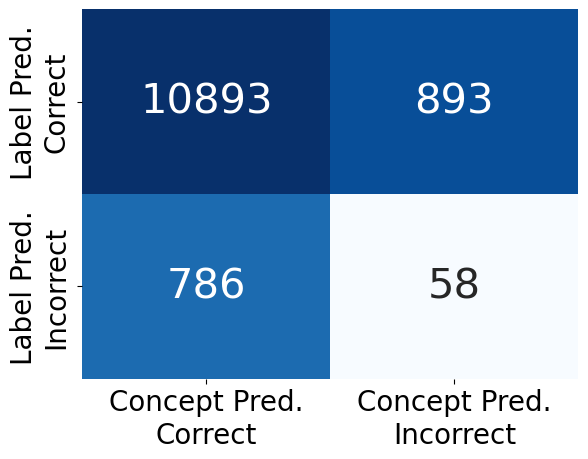

In [45]:
plot_cl_matrix(bcbm_cf_matrix)

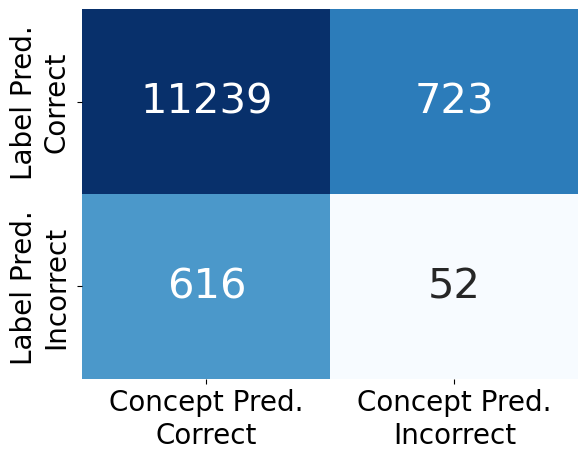

In [48]:
plot_cl_matrix(fcbm_cf_matrix)